## Polytope Climate-DT example notebook

This notebook shows how to use earthkit-data and earthkit-plots to pull destination-earth data from LUMI and plot it using earthkit-plots on a domain.

Before running the notebook you need to set up your credentials. See the main readme of this repository for different ways to do this or use the following cells to authenticate.

You will need to generate your credentials using the desp-authentication.py script.

This can be run as follows:

In [15]:
%%capture cap
%run ../desp-authentication.py

Exception: File `'../desp-authentication.py'` not found.

This will generate a token that can then be used by earthkit and polytope.

In [16]:
output_1 = cap.stdout.split('}\n')
access_token = output_1[-1][0:-1]

# Requirements
To run this notebook install the following:
* pip install earthkit-data
* pip install earthkit-plots
* pip install earthkit-regrid  (Optional for spectral variables)
* pip install cf-units         (Optional for unit conversion in maps)

If you do not have eccodes installed please install eccodes using conda as it is a dependency of earthkit, or install earthkit via conda

* conda install eccodes -c conda-forge
* conda install earthkit-data -c conda-forge

In [17]:
import earthkit.data
import earthkit.plots
import earthkit.regrid
from polytope.api import Client

In [18]:
client = Client(
    address="polytope.lumi.apps.dte.destination-earth.eu")

request = {
    'activity': 'ScenarioMIP',
    'class': 'd1',
    'dataset': 'climate-dt',
    'date': '20200102',
    'experiment': 'SSP3-7.0',
    'expver': '0001',
    'generation': '1',
    'levtype': 'sfc',
    'model': 'IFS-NEMO',
    'param': '134/165/166',
    'realization': '1',
    'resolution': 'standard',
    'stream': 'clte',
    'time': '0100', # '0100/0200/0300/0400/0500/0600'
    'type': 'fc'
}

files = client.retrieve("destination-earth", request, "data/climate-dt-earthkit-example-domain.grib") 

2025-07-07 16:57:53 - INFO - Sending request...
{'request': 'activity: ScenarioMIP\n'
            'class: d1\n'
            'dataset: climate-dt\n'
            "date: '20200102'\n"
            'experiment: SSP3-7.0\n'
            "expver: '0001'\n"
            "generation: '1'\n"
            'levtype: sfc\n'
            'model: IFS-NEMO\n'
            'param: 134/165/166\n'
            "realization: '1'\n"
            'resolution: standard\n'
            'stream: clte\n'
            "time: '0100'\n"
            'type: fc\n',
 'verb': 'retrieve'}
2025-07-07 16:57:54 - INFO - Request accepted. Please poll ./d80a4f4d-2230-44c6-909a-6352552a0aee for status
2025-07-07 16:57:54 - INFO - Checking request status (d80a4f4d-2230-44c6-909a-6352552a0aee)...
2025-07-07 16:57:55 - INFO - The current status of the request is 'queued'
2025-07-07 16:57:55 - INFO - The current status of the request is 'processing'
2025-07-07 16:57:58 - INFO - The current status of the request is 'processed'
2025-07-07 1

In [19]:
data = earthkit.data.from_source("file", "data/climate-dt-earthkit-example-domain.grib")

In [20]:
data.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,sp,surface,0,20200102,100,0,fc,None,healpix
1,ecmf,10u,heightAboveGround,10,20200102,100,0,fc,None,healpix
2,ecmf,10v,heightAboveGround,10,20200102,100,0,fc,None,healpix


/opt/homebrew/Caskroom/miniforge/base/envs/earthkit_latest/lib/python3.13/site-packages/earthkit/plots/components/subplots.py:1126: UserWarning: block is deprecated and will be removed in a future release. Please use grid_cells instead.
  warnings.warn(


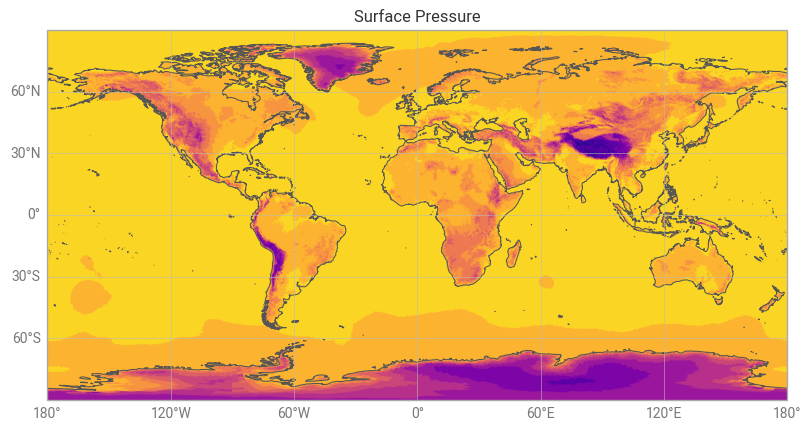

In [21]:
chart = earthkit.plots.Map(extent=[-180, 180, -90, 90])
chart.block(
    data[0]
)

chart.title("Surface Pressure")
chart.coastlines()
chart.gridlines()
chart.show()

In [22]:
# Regrid t=from healpix for conversion to xarray
data_latlon = earthkit.regrid.interpolate(data, out_grid={"grid": [0.1,0.1]}, method="linear")
# Convert data to xarray
data_latlon.to_xarray()

<xarray.Dataset> Size: 156MB
Dimensions:    (latitude: 1801, longitude: 3600)
Coordinates:
  * latitude   (latitude) float64 14kB 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * longitude  (longitude) float64 29kB 0.0 0.1 0.2 0.3 ... 359.7 359.8 359.9
Data variables:
    10u        (latitude, longitude) float64 52MB ...
    10v        (latitude, longitude) float64 52MB ...
    sp         (latitude, longitude) float64 52MB ...
Attributes:
    class:        d1
    stream:       clte
    levtype:      sfc
    type:         fc
    expver:       0001
    date:         20200102
    time:         100
    Conventions:  CF-1.8
    institution:  ECMWF

Now we will plot a specific area using earthkit-plots. In this case we will plot the data we have retrieved over Europe.

/opt/homebrew/Caskroom/miniforge/base/envs/earthkit_latest/lib/python3.13/site-packages/earthkit/plots/components/subplots.py:1126: UserWarning: block is deprecated and will be removed in a future release. Please use grid_cells instead.
  warnings.warn(


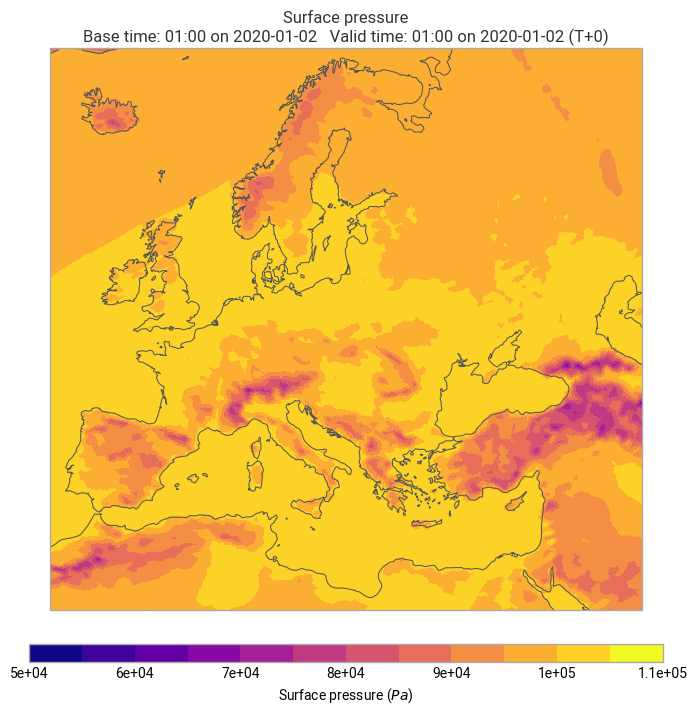

In [26]:
chart = earthkit.plots.Map(domain=["Europe"])

chart.block(data_latlon[0])
chart.title()
chart.legend()

chart.coastlines()

chart.show()

We can plot all the parameters we have as well using earthkit-plots

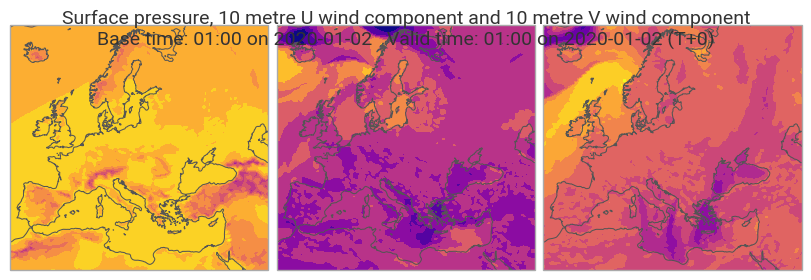

<Figure size 800x300 with 0 Axes>

In [24]:
figure = earthkit.plots.Figure(columns=3, size=(8, 3), domain="Europe")

for i, _ in enumerate(range(len(data.ls()))):
      figure.add_map(0, i)
figure.contourf(data)
figure.land()
figure.coastlines()
figure.title()
figure.show()